In [1]:
cd C:\\Users\\abelr\\WORK\\GC_JAMES

C:\Users\abelr\WORK\GC_JAMES


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from netCDF4 import Dataset
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from cmocean import cm
from matplotlib import ticker
import xarray as xr
import sys
from pathlib2 import Path

NB_CM_IN_INCH = 2.54

def convert_cm_to_inch(val):
    return val / NB_CM_IN_INCH

def mean(T,grid3d_in):
    return np.nansum(np.nansum(T*grid3d_in,2),2)/np.nansum(np.nansum(grid3d_in,1),1)[None,:]

def box_mean(var1,var2,i1,i2,j1,j2):
    grid_part = grid[0:10,j1:j2,i1:i2]
    diff      = np.nansum(np.nansum(np.nansum((var2-var1)[:,:,j1:j2,i1:i2] * grid_part,1),1),1)/np.nansum(grid_part)
    diff_perc = diff / (np.nansum(np.nansum(np.nansum((var1[:,:,j1:j2,i1:i2]) * grid_part,1),1),1)\
                        /np.nansum(grid_part)) *100 # in %
    return diff, diff_perc

def area_mean(T,grid3d_in,i1,i2,j1,j2):
    return np.nansum(np.nansum(T[:,:j1:j2,i1:i2]*grid3d_in[None,:j1:j2,i1:i2],2),2)/np.nansum(np.nansum(grid3d_in,1),1)[None,:]

def plot_drift(var):
    cs = plt.contourf(np.arange(0,47),deptht,var,levs,cmap=cm.balance,extend='both')
    plt.gca().invert_yaxis()
    plt.ylim(1000,0)
    plt.grid()
    return cs

def calc_means(data):
    glob_mean   = mean(data[:,:,:,:],grid3d)
    pac_mean    = mean(data[:,:,:,:],grid3d_pac)
    atl_mean    = mean(data[:,:,:,:],grid3d_atl)
    ind_mean    = mean(data[:,:,:,:],grid3d_ind)
    SO_mean     = mean(data[:,:,:,:],grid3d_SO)
    arctic_mean = mean(data[:,:,:,:],grid3d_arctic)
    return glob_mean, pac_mean, atl_mean, ind_mean, SO_mean, arctic_mean

## Build global and basin means. Data not provided.

In [3]:
CTRL_T_data      = xr.open_dataset('ORCA025.L46-KRA031_5d_1958__20000101_20041231_grid_T_votemper.nc')
deptht  = np.array(CTRL_T_data.deptht)

In [4]:
%%time
save = False
if save:
    CTRL_T_data      = xr.open_dataset('ORCA025.L46-KRA031_5d_1958__20000101_20041231_grid_T_votemper.nc')
    CTRL_T_1958__2000_2004 = CTRL_T_data.votemper.squeeze()
    
    CG_T_data        = xr.open_dataset('ORCA025.L46-KRA032_5d_1958__20000101_20041231_grid_T_votemper.nc')
    CG_T_1958__2000_2004   = CG_T_data.votemper.squeeze()

    CG_T_1958        = CG_T_data.votemper.squeeze()
    # NaN over land
    CTRL_T_1958__2000_2004 = CTRL_T_1958__2000_2004.where(CTRL_T_1958__2000_2004!= 0)
    CG_T_1958__2000_2004   = CG_T_1958__2000_2004.where(CG_T_1958__2000_2004!= 0)
    
    maskdata = xr.open_dataset('F:\\BACKUP\\MASK025\\mask.nc')

    e1t=maskdata.e1t.squeeze()
    e2t=maskdata.e2t.squeeze()
    e3t=maskdata.e3t.squeeze()
    ocean=maskdata.tmaskutil[0,:,:].squeeze()
    tmask = maskdata.tmask[:,:,:,:].squeeze()

    grid3d = np.array(tmask*e1t*e2t) #no e3t because no vertical integration

    maskdata = xr.open_dataset('F:\\BACKUP\\MASK025\\ORCA025.L46_new_maskglo.nc')
    tmaskatl   = np.array(maskdata.tmaskatl.squeeze())
    tmaskpac   = np.array(maskdata.tmaskpac.squeeze())
    tmaskind   = np.array(maskdata.tmaskind.squeeze())
    grid3d_atl = grid3d*tmaskatl
    grid3d_pac = grid3d*tmaskpac
    grid3d_ind = grid3d*tmaskind

    # define Artic and Southern Ocean
    arctic = np.array(ocean -(tmaskatl+tmaskpac+tmaskind))
    arctic[0:800] = 0

    SO = np.array(ocean -(tmaskatl+tmaskpac+tmaskind))
    SO[300:] = 0

    grid3d_arctic = grid3d*arctic[None,:,:]
    grid3d_SO    = grid3d*SO[None,:,:]
    
    # calculate means
    CTRL_glob_mean, CTRL_pac_mean, CTRL_atl_mean, CTRL_ind_mean, CTRL_SO_mean, CTRL_arctic_mean = calc_means(CTRL_T_1958__2000_2004)
    CG_glob_mean, CG_pac_mean, CG_atl_mean, CG_ind_mean, CG_SO_mean, CG_arctic_mean             = calc_means(CG_T_1958__2000_2004)
    
    #save means
    data=xr.Dataset({'CG_glob_mean': (['time','depth',],     CG_glob_mean),\
                     'CTRL_glob_mean': (['time','depth',],   CTRL_glob_mean),\
                     'CG_pac_mean': (['time','depth',],     CG_pac_mean),\
                     'CTRL_pac_mean': (['time','depth',],   CTRL_pac_mean),\
                     'CG_atl_mean': (['time','depth',],     CG_atl_mean),\
                     'CTRL_atl_mean': (['time','depth',],   CTRL_atl_mean),\
                     'CG_ind_mean': (['time','depth',],     CG_ind_mean),\
                     'CTRL_ind_mean': (['time','depth',],   CTRL_ind_mean),\
                     'CG_arctic_mean': (['time','depth',],     CG_arctic_mean),\
                     'CTRL_arctic_mean': (['time','depth',],   CTRL_arctic_mean),\
                     'CG_SO_mean': (['time','depth',],     CG_SO_mean),\
                     'CTRL_SO_mean': (['time','depth',],   CTRL_SO_mean)})
    T_ave = "CTRL_CG_averaged_T.nc"
    data.to_netcdf(path=T_ave)

Wall time: 0 ns


### load basin means/averages

In [5]:
T_ave   = xr.open_dataset('CTRL_CG_averaged_T.nc')

# ORCA025 model drift

maximum in the Indian: 0.06744158464119288


C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarni

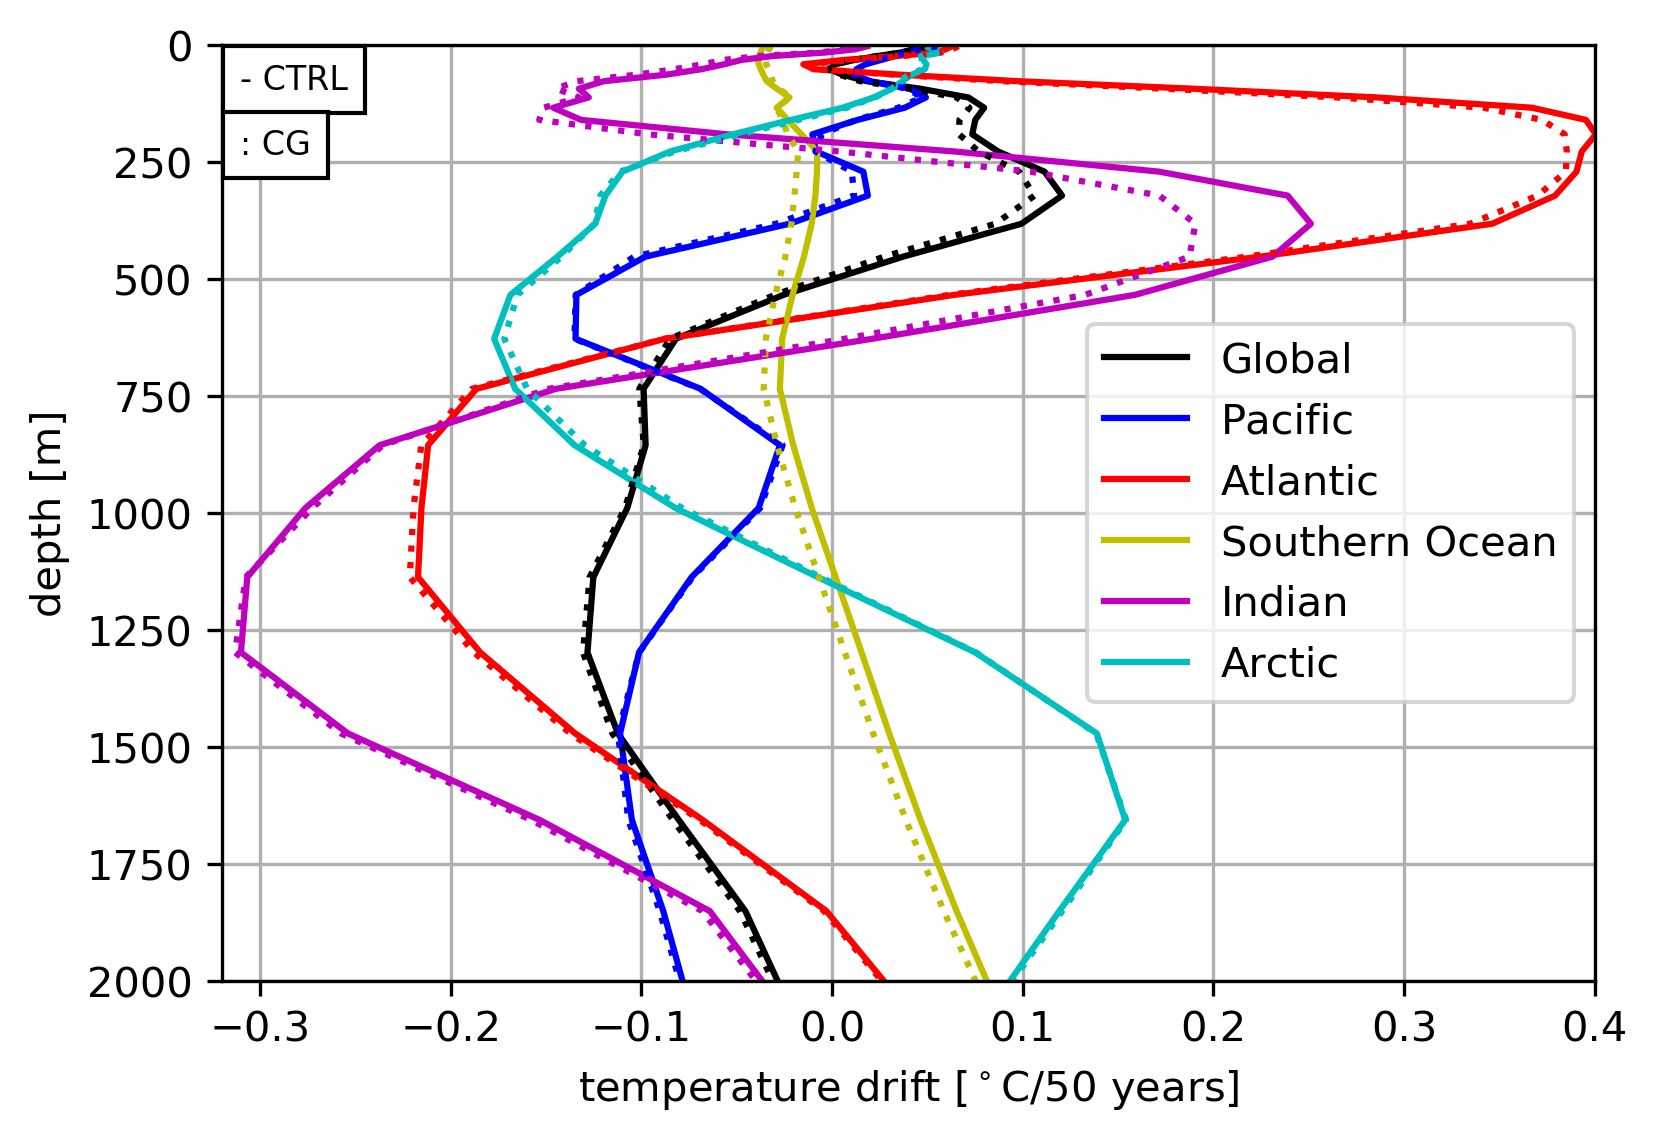

In [6]:
fig = plt.figure(figsize=(convert_cm_to_inch(15), convert_cm_to_inch(10.5)), dpi=300)
gs = gridspec.GridSpec(90, 90)

                            #a
ax1 = plt.subplot(gs[0:90, 0:90])

y = 5 # last 5 years
plt.plot(np.nanmean((T_ave.CTRL_glob_mean[-5:,:]   - T_ave.CTRL_glob_mean[0,:]),0),deptht,'k',label='Global')
plt.plot(np.nanmean((T_ave.CTRL_pac_mean[-5:,:]    - T_ave.CTRL_pac_mean[0,:]),0),deptht,'b',label='Pacific')
plt.plot(np.nanmean((T_ave.CTRL_atl_mean[-5:,:]    - T_ave.CTRL_atl_mean[0,:]),0),deptht,'r',label='Atlantic')
plt.plot(np.nanmean((T_ave.CTRL_SO_mean[-5:,:]     - T_ave.CTRL_SO_mean[0,:]),0),deptht,'y',label='Southern Ocean')
plt.plot(np.nanmean((T_ave.CTRL_ind_mean[-5:,:]    - T_ave.CTRL_ind_mean[0,:]),0),deptht,'m',label='Indian')
plt.plot(np.nanmean((T_ave.CTRL_arctic_mean[-5:,:] - T_ave.CTRL_arctic_mean[0,:]),0),deptht,'c',label='Arctic')
# plt.plot(np.nanmean((T_ave.CG_T_ind_mean[-5:,:]-T_ave.CTRL_T_ind_mean[0,:]),0),deptht)

plt.legend(loc='right')
plt.plot(np.nanmean((T_ave.CG_glob_mean[-5:,:]   - T_ave.CTRL_glob_mean[0,:]),0),deptht,':k',label='Global')
plt.plot(np.nanmean((T_ave.CG_pac_mean[-5:,:]    - T_ave.CTRL_pac_mean[0,:]),0),deptht,':b',label='Pacific')
plt.plot(np.nanmean((T_ave.CG_atl_mean[-5:,:]    - T_ave.CTRL_atl_mean[0,:]),0),deptht,':r',label='Atlantic')
plt.plot(np.nanmean((T_ave.CG_SO_mean[-5:,:]     - T_ave.CTRL_SO_mean[0,:]),0),deptht,':y',label='Southern Ocean')
plt.plot(np.nanmean((T_ave.CG_ind_mean[-5:,:]    - T_ave.CTRL_ind_mean[0,:]),0),deptht,':m',label='Indian')
plt.plot(np.nanmean((T_ave.CG_arctic_mean[-5:,:] - T_ave.CTRL_arctic_mean[0,:]),0),deptht,':c',label='Arctic')
plt.gca().invert_yaxis()
plt.ylim(2000,0)
plt.xlim(-0.32,0.4)
plt.grid()
plt.xlabel(r'temperature drift [$^\circ$C/50 years]')
plt.ylabel(r'depth [m]')

i=0.0123
j=0.963
plt.text(i+0.001,j,'- CTRL',ha='left',va='center',transform=ax1.transAxes,bbox={'facecolor':'white'},fontsize=8)
plt.text(i+0.001,j-0.07,': CG',ha='left',va='center',transform=ax1.transAxes,bbox={'facecolor':'white'},fontsize=8)

# plt.savefig('fig4_temp_drift.png',dpi=300)
print('maximum in the Indian:',np.nanmax(np.nanmean(T_ave.CTRL_ind_mean[-5:,:]-T_ave.CG_ind_mean[-5:,:],0)))

C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarni

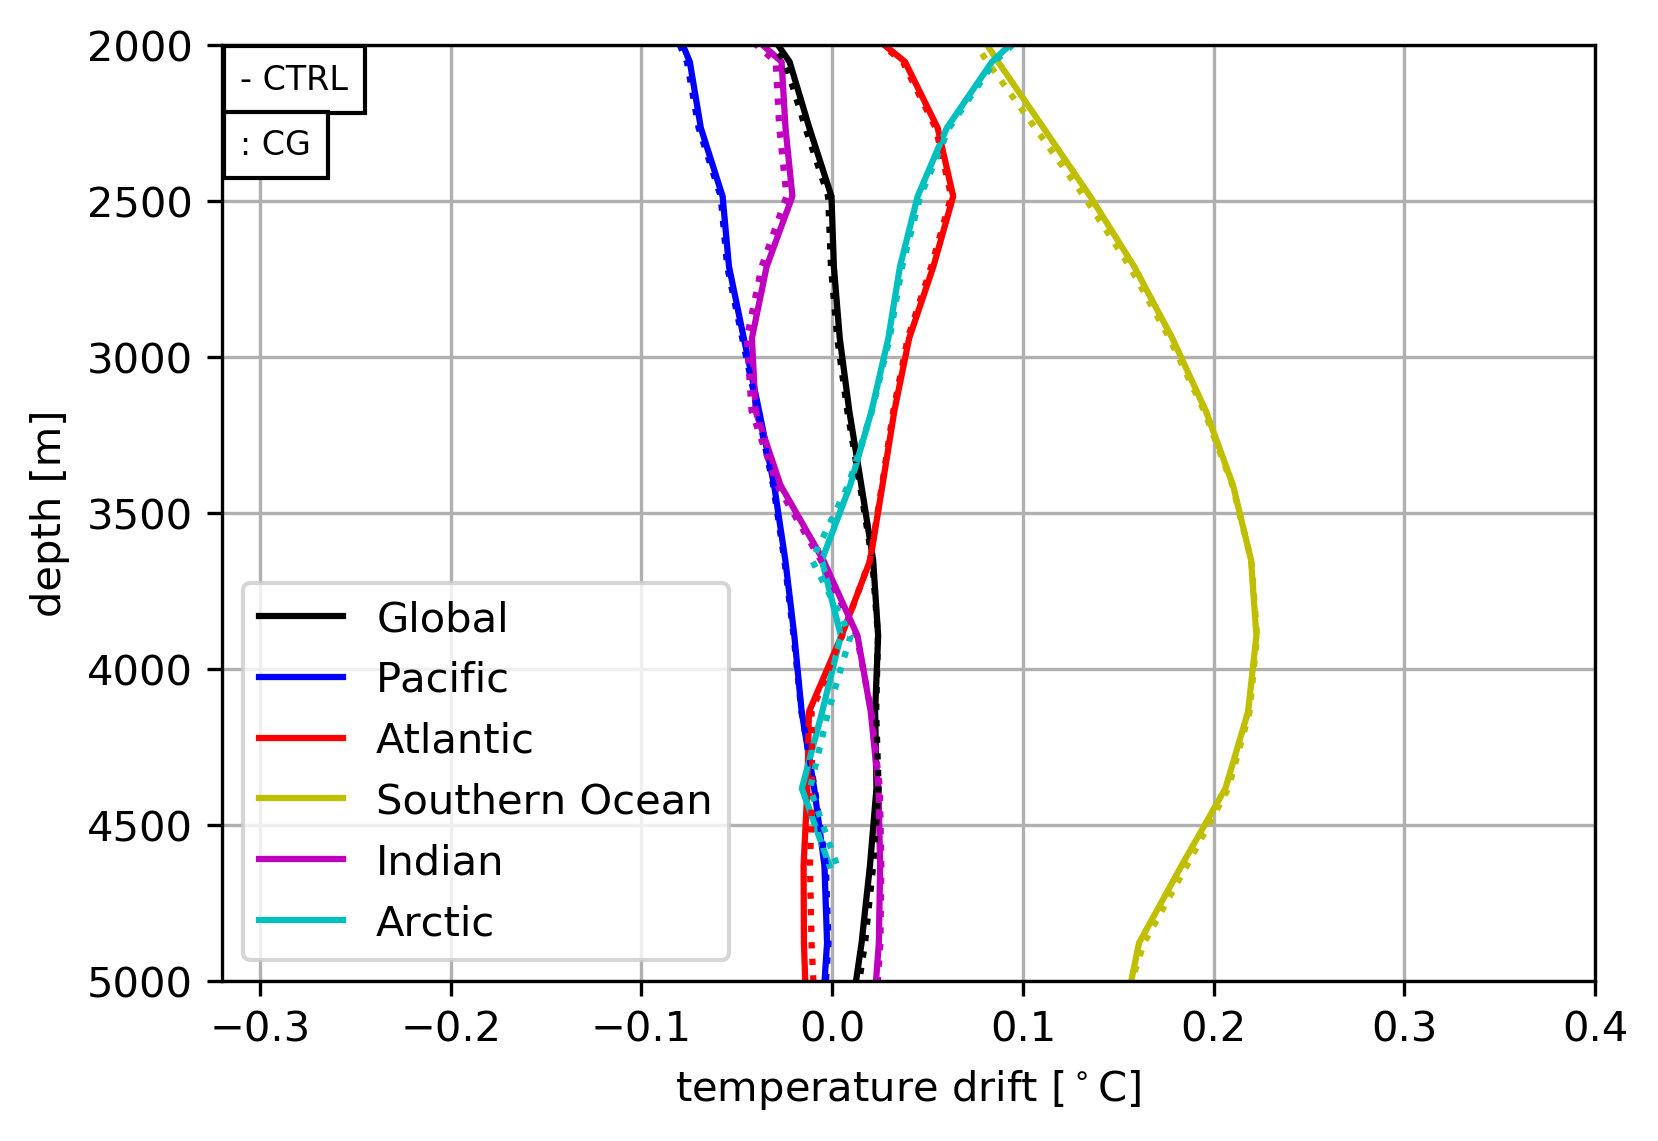

In [7]:
fig = plt.figure(figsize=(convert_cm_to_inch(15), convert_cm_to_inch(10.5)), dpi=300)
gs = gridspec.GridSpec(90, 90)

                            #a
ax1 = plt.subplot(gs[0:90, 0:90])

y = 5 # last 5 years
plt.plot(np.nanmean((T_ave.CTRL_glob_mean[-5:,:]   - T_ave.CTRL_glob_mean[0,:]),0),deptht,'k',label='Global')
plt.plot(np.nanmean((T_ave.CTRL_pac_mean[-5:,:]    - T_ave.CTRL_pac_mean[0,:]),0),deptht,'b',label='Pacific')
plt.plot(np.nanmean((T_ave.CTRL_atl_mean[-5:,:]    - T_ave.CTRL_atl_mean[0,:]),0),deptht,'r',label='Atlantic')
plt.plot(np.nanmean((T_ave.CTRL_SO_mean[-5:,:]     - T_ave.CTRL_SO_mean[0,:]),0),deptht,'y',label='Southern Ocean')
plt.plot(np.nanmean((T_ave.CTRL_ind_mean[-5:,:]    - T_ave.CTRL_ind_mean[0,:]),0),deptht,'m',label='Indian')
plt.plot(np.nanmean((T_ave.CTRL_arctic_mean[-5:,:] - T_ave.CTRL_arctic_mean[0,:]),0),deptht,'c',label='Arctic')
# plt.plot(np.nanmean((T_ave.CG_T_ind_mean[-5:,:]-T_ave.CTRL_T_ind_mean[0,:]),0),deptht)

plt.legend()
plt.plot(np.nanmean((T_ave.CG_glob_mean[-5:,:]   - T_ave.CTRL_glob_mean[0,:]),0),deptht,':k',label='Global')
plt.plot(np.nanmean((T_ave.CG_pac_mean[-5:,:]    - T_ave.CTRL_pac_mean[0,:]),0),deptht,':b',label='Pacific')
plt.plot(np.nanmean((T_ave.CG_atl_mean[-5:,:]    - T_ave.CTRL_atl_mean[0,:]),0),deptht,':r',label='Atlantic')
plt.plot(np.nanmean((T_ave.CG_SO_mean[-5:,:]     - T_ave.CTRL_SO_mean[0,:]),0),deptht,':y',label='Southern Ocean')
plt.plot(np.nanmean((T_ave.CG_ind_mean[-5:,:]    - T_ave.CTRL_ind_mean[0,:]),0),deptht,':m',label='Indian')
plt.plot(np.nanmean((T_ave.CG_arctic_mean[-5:,:] - T_ave.CTRL_arctic_mean[0,:]),0),deptht,':c',label='Arctic')
plt.gca().invert_yaxis()
plt.ylim(5000,2000)
plt.xlim(-0.32,0.4)
plt.grid()
plt.xlabel(r'temperature drift [$^\circ$C]')
plt.ylabel(r'depth [m]')

i=0.0123
j=0.963
plt.text(i+0.001,j,'- CTRL',ha='left',va='center',transform=ax1.transAxes,bbox={'facecolor':'white'},fontsize=8)
plt.text(i+0.001,j-0.07,': CG',ha='left',va='center',transform=ax1.transAxes,bbox={'facecolor':'white'},fontsize=8)

plt.savefig('tempdrift_vertical+CG__below2000.png',dpi=300, transparent=True)

In [8]:
!conda list

# packages in environment at C:\Users\abelr\Anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py36_0  
_tflow_select             2.2.0                     eigen  
absl-py                   0.6.1                    py36_0  
alabaster                 0.7.12                   py36_0  
anaconda                  custom           py36h363777c_0  
anaconda-client           1.7.2                    py36_0  
anaconda-navigator        1.9.6                    py36_0  
anaconda-project          0.8.2                    py36_0  
asn1crypto                0.24.0                   py36_0  
astor                     0.7.1                    py36_0  
astroid                   2.1.0                    py36_0  
astropy                   3.1              py36he774522_0  
atomicwrites              1.2.1                    py36_0  
attrs                     18.2.0           py36h28b3542_0  
babel                     2.6.0     

In [9]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: win-64
@EXPLICIT
https://repo.anaconda.com/pkgs/main/win-64/_tflow_select-2.2.0-eigen.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/blas-1.0-mkl.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/ca-certificates-2018.03.07-0.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/conda-env-2.6.0-1.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/icc_rt-2019.0.0-h0cc432a_1.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/intel-openmp-2019.1-144.tar.bz2
https://repo.anaconda.com/pkgs/msys2/win-64/msys2-conda-epoch-20160418-1.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/pandoc-2.2.3.2-0.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/vs2015_runtime-14.15.26706-h3a45250_0.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/winpty-0.4.3-4.tar.bz2
https://repo.anaconda.com/pkgs/msys2/win-64/m2w64-gmp-6.1.0-2.tar.bz2
https://repo.anaconda.com/pkgs/msys2/win-64/m2w64